# Deep Learning for Deciphering Traffic Signs
_________________________________________________________________________________________________________________________________________________________________________________

##### Contributors:
 Victor Floriano, Yifan Fan, Jose Salerno

## Problem Statement & Motivation
As the world advances towards autonomous vehicles, our team has observed the remarkable efforts of large car manufacturers, who are working with data scientists to develop fully autonomous cars. Our team is excited to contribute to the development of this technology by creating a neural network model that will be able to classify different traffic signs. Our ultimate goal is to assist car makers in overcoming the challenges they may face in implementing neural network models that effectively read traffic signs and further their efforts toward a fully autonomous car or assisted driving. We believe autonomous driving to be an important problem to solve due to the great economic benefits it can generate for car manufacturers and the improvement of general driving safety.

## Data Preparation
 We've selected the German Traffic Sign Recognition Benchmark (GTSRB) as our primary dataset. It's renowned for its complexity, featuring over 50,000 images across more than 40 classes of traffic signs. The GTSRB is publicly accessible through two resources. To efficiently manage the extensive and complex GTSRB dataset, our strategy integrates preprocessing for uniformity, data augmentation for robustness, and batch processing for computational efficiency. We'll employ distributed computing to parallelize operations, enhancing processing speed, and use stratified sampling for quick experimentation without compromising representativeness.



---





# Project Breakdown Summary
1. Data Cleaning and Transformation
3. MLP Models
4. CNN Model
5. Pre-trained Model
6. SVM
7. Results
8. Future Work
9. Conclusions

# 1. Data Cleaning and Transformation

## Importing Packages

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
enable_wandb = True
use_gpu = True
gpu_available = torch.cuda.is_available()
gpu_available

True

In [ ]:
if enable_wandb:
  !pip install wandb -qU
  import wandb
  wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#Loading images - from Datacamp CNN course (cloud example)
from torchvision.datasets import ImageFolder
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32))
])

dataset_train = ImageFolder(
    '/content/drive/MyDrive/BA865 - Group Project/GTSRBkaggle/Train',
    transform = train_transforms
)

## Visualizing Data

torch.Size([1, 3, 32, 32])
Label: tensor([3])
tensor([3])


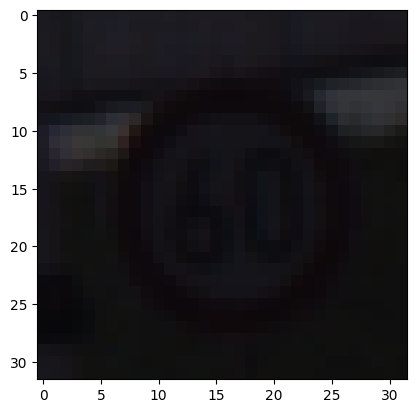

In [ ]:
from torch.utils.data import DataLoader

#Trying to display images
dataloader_train = DataLoader(
    dataset_train,
    shuffle=True,
    batch_size=1,
)

image, label = next(iter(dataloader_train))
print(image.shape)
print('Label:',label)
print(label)

#Change image into right shape for visualization
image = image.squeeze().permute(1,2,0)

plt.imshow(image)
plt.show()

In [ ]:
# classes = { 0:'Speed limit (20km/h)',
#             1:'Speed limit (30km/h)',
#             2:'Speed limit (50km/h)',
#             3:'Speed limit (60km/h)',
#             4:'Speed limit (70km/h)',
#             5:'Speed limit (80km/h)',
#             6:'End of speed limit (80km/h)',
#             7:'Speed limit (100km/h)',
#             8:'Speed limit (120km/h)',
#             9:'No passing',
#             10:'No passing veh over 3.5 tons',
#             11:'Right-of-way at intersection',
#             12:'Priority road',
#             13:'Yield',
#             14:'Stop',
#             15:'No vehicles',
#             16:'Veh > 3.5 tons prohibited',
#             17:'No entry',
#             18:'General caution',
#             19:'Dangerous curve left',
#             20:'Dangerous curve right',
#             21:'Double curve',
#             22:'Bumpy road',
#             23:'Slippery road',
#             24:'Road narrows on the right',
#             25:'Road work',
#             26:'Traffic signals',
#             27:'Pedestrians',
#             28:'Children crossing',
#             29:'Bicycles crossing',
#             30:'Beware of ice/snow',
#             31:'Wild animals crossing',
#             32:'End speed + passing limits',
#             33:'Turn right ahead',
#             34:'Turn left ahead',
#             35:'Ahead only',
#             36:'Go straight or right',
#             37:'Go straight or left',
#             38:'Keep right',
#             39:'Keep left',
#             40:'Roundabout mandatory',
#             41:'End of no passing',
#             42:'End no passing veh > 3.5 tons' }

# 1. Hyperparameters

In [ ]:
configs = {
    "experiment_name": "First Experiement Traffic Signs ",
    "freeze_feature_extraction_layers": False,
    "pretrained":False,
    "efficientnet":False,
    "data_augmentation":True,
    "transferlearning": True,

    # Data
    "img_dimensions" : (3,32,32),
    "batch_size" : 32,
    "num_classes" : 43,

    # CNN
    "filter_sizes" : [4,8],
    "kernel_size" : 5,
    "stride": 2,
    "padding":1,

    #Optimzation
    "learning_rate" : 0.01,
    "epochs" : 70,
    "weight_decay" : 0.00001
}

## 2. Data Augmentation


In [ ]:
if configs["data_augmentation"]:
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(0.5),
      transforms.Resize(32),
      transforms.RandomRotation(45),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
else:
  transform = transforms.Compose([
      transforms.Resize(32),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

In [ ]:
train_dataset, val_dataset = random_split(dataset_train, [0.8, 0.2])

In [ ]:
train_loader = DataLoader(dataset = train_dataset, batch_size = configs['batch_size'], shuffle = True)
val_loader = DataLoader(dataset = val_dataset, batch_size = configs['batch_size'], shuffle = False)

# 2. Pytorch Sequential MLP


#### Sequential Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [60]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*32*3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc4 = nn.Linear(64, 43)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

In [61]:
model = MLP()

In [62]:
pip install torchinfo

In [63]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Flatten: 1-1                           --
├─Linear: 1-2                            786,688
├─Linear: 1-3                            32,896
├─Linear: 1-4                            8,256
├─Dropout: 1-5                           --
├─Linear: 1-6                            2,795
Total params: 830,635
Trainable params: 830,635
Non-trainable params: 0

In [64]:
criteron = nn.CrossEntropyLoss()

In [65]:
optimizer = optim.SGD(model.parameters(), momentum=0.8, lr=configs['learning_rate'], weight_decay=configs['weight_decay'])

In [66]:
if enable_wandb:
  wandb.init(
    project="Deciphering Traffic Signs",
    name=configs["experiment_name"],
    config=configs)

In [67]:
!pip install -U torchmetrics
import torchmetrics

In [68]:
def get_accuracy(dataloader, model):
    acc = torchmetrics.Accuracy()
    with torch.no_grad():
        for images, labels in dataloader:
            if gpu_available and use_gpu:
                images = images.cuda()
                labels = labels.cuda()

            outputs = model(images)
            acc = acc + torch.sum(torch.argmax(outputs, axis = 1) == labels)

        acc = acc / len(dataloader.dataset)
        return acc

In [69]:
def get_loss(loader):
    with torch.no_grad():
        loss = 0
        for i, (images, labels) in enumerate(loader):
            if gpu_available and use_gpu:
                images = images.cuda()
                labels = labels.cuda()

            outputs = model(images)
            loss = loss + criterion(outputs, labels)
        return loss/len(loader)

In [70]:
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(model.state_dict(), "./best_model.pt")

        elif validation_loss > self.min_validation_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [71]:
if gpu_available and use_gpu:
    model = model.cuda()

In [74]:
early_stopper = EarlyStopper(patience=7)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=3)

# Training
for epoch in range(configs["epochs"]):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        if gpu_available and use_gpu:
          images = images.cuda()
          labels = labels.cuda()

        outputs = model(images)
        loss = criteron(outputs, labels)
        loss.backward()
        optimizer.step()

        if i %100 == 0:
          print("Epoch", epoch+ 1, " batch", i+1, ". Training Loss: ", loss.item())
          if enable_wandb:
            wandb.log({"loss": loss})

    train_acc = get_accuracy(train_loader, model)
    test_acc = get_accuracy(val_loader, model)

    validation_loss = get_loss(val_loader)
    wandb.log({"val_loss": validation_loss})

    print(f'Epoch [{epoch + 1}/{configs["epochs"]}], LR: {optimizer.param_groups[0]["lr"]}, Validation Loss: {validation_loss.item():.4f}, Train Accuracy: {train_acc.item():.4f}, Validation Accuracy: {test_acc.item():.4f}')
    if enable_wandb:
      wandb.log({"epoch": epoch + 1, "LR": {optimizer.param_groups[0]['lr']}, "train_accuracy": train_acc.item(), "val_accuracy": test_acc.item()})

    scheduler.step(validation_loss)

    if early_stopper.early_stop(validation_loss):
        print("Validation loss hasn't dropped. Early stopping!")
        break

Epoch 1  batch 1 . Training Loss:  3.761277914047241
Epoch 1  batch 101 . Training Loss:  3.7616569995880127
Epoch 1  batch 201 . Training Loss:  3.761273145675659
Epoch 1  batch 301 . Training Loss:  3.76131010055542
Epoch 1  batch 401 . Training Loss:  3.761333465576172
Epoch 1  batch 501 . Training Loss:  3.7609474658966064
Epoch 1  batch 601 . Training Loss:  3.7609446048736572


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-74-c28cbfa44e04>", line 6, in <cell line: 5>
    for i, (images, labels) in enumerate(train_loader):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 631, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 675, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py", line 399, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
  File "/usr/local/lib/python3.10/dist-pa

TypeError: object of type 'NoneType' has no len()

# 3. Pytoch CNN Model

In [75]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model_CNN = nn.Sequential(
          torch.nn.Conv2d(configs['img_dimensions'][0], configs['filter_sizes'][0], configs['kernel_size'], stride = configs['stride'], padding = configs['padding']),
          torch.nn.ReLU(),
          torch.nn.Conv2d(configs['img_dimensions'][0], configs['filter_sizes'][0], configs['kernel_size'], stride = configs['stride'], padding = configs['padding']),
          torch.nn.MaxPool2d(2),
          nn.Flatten(),
          nn.Linear(64, 43)
        )

    def forward(self, x):
        x = x.view(-1, configs['img_dimensions'][0], configs['img_dimnesions'][1], configs['img_dimensions'][2])
        return self.model(X)

In [76]:
model_CNN = MLP()
summary(model_CNN)

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       304
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       304
│    └─MaxPool2d: 2-4                    --
│    └─Flatten: 2-5                      --
│    └─Linear: 2-6                       2,795
Total params: 3,403
Trainable params: 3,403
Non-trainable params: 0

In [77]:
early_stopper = EarlyStopper(patience=7)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=3)

# Training
for epoch in range(configs["epochs"]):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        if gpu_available and use_gpu:
          images = images.cuda()
          labels = labels.cuda()

        outputs = model(images)
        loss = criteron(outputs, labels)
        loss.backward()
        optimizer.step()

        if i %100 == 0:
          print("Epoch", epoch+ 1, " batch", i+1, ". Training Loss: ", loss.item())
          if enable_wandb:
            wandb.log({"loss": loss})

    train_acc = get_accuracy(train_loader, model)
    test_acc = get_accuracy(val_loader, model)

    validation_loss = get_loss(val_loader)
    wandb.log({"val_loss": validation_loss})

    print(f'Epoch [{epoch + 1}/{configs["epochs"]}], LR: {optimizer.param_groups[0]["lr"]}, Validation Loss: {validation_loss.item():.4f}, Train Accuracy: {train_acc.item():.4f}, Validation Accuracy: {test_acc.item():.4f}')
    if enable_wandb:
      wandb.log({"epoch": epoch + 1, "LR": {optimizer.param_groups[0]['lr']}, "train_accuracy": train_acc.item(), "val_accuracy": test_acc.item()})

    scheduler.step(validation_loss)

    if early_stopper.early_stop(validation_loss):
        print("Validation loss hasn't dropped. Early stopping!")
        break

Epoch 1  batch 1 . Training Loss:  3.761180877685547


KeyboardInterrupt: 

## Sources:

- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html